# Global (Imports, Constants, Utils etc) 



## GPU type

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 23 21:25:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 32%   37C    P5    21W / 170W |  12002MiB / 12045MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [3]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [4]:
import os
import sys
import random
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer



## Constant definision

In [5]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)


MAGNOMETER_SENSORS = [ "magnetometer_magnetic_field_body_x",
                      "magnetometer_magnetic_field_body_y", 
                      "magnetometer_magnetic_field_body_z"]
BOROMETER_SENSORS = ["barometer_altitude", "barometer_pressure"]
ROTOR_SPEEDS = ["rotor_a_speed", "rotor_b_speed", "rotor_c_speed", "rotor_d_speed"]
ACCELOMETER_SENSORS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                       "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                       "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                       "angular_velocity_x", "angular_velocity_y", "angular_velocity_z"]

ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
ANGULAR_VELOCITY_SENSORS = ["angular_velocity_x", "angular_velocity_y"]
LINEAR_ACCELERATION_SENSORS = ["linear_acceleration_x", "linear_acceleration_y"]
ANGULAR_ACCELERATION_SENSORS = [ "angular_acceleration_x", "angular_acceleration_y"]

INPUT_COLUMNS = [*ORIENTATION_SENSORS, *LINEAR_ACCELERATION_SENSORS]

OUTPUT_COLUMNS = ["linear_velocity_x", "linear_velocity_y"]


In [6]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)
    random.shuffle(all_csv_files)

    # Orders the "manual" files to the end (They are more likely represent 
    # the test user). So this data should be used as test
    # auto_genereted_flights = [recording_file for recording_file in all_csv_files 
    #                           if not recording_file.startswith("manual")]
    # manual_generated_flights = [recording_file for recording_file in all_csv_files 
    #                           if recording_file.startswith("manual_2022:04:22_20:34:20_record.csv")]
    all_csv_files.remove("bot-train-1_23Apr_18:24_record.csv")

    return all_csv_files


In [7]:
# Set float 64
tf.keras.backend.set_floatx('float32')

## Utils


### Save and Load models

In [8]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

In [9]:

def ewma_vectorized_safe(data, alpha, row_size=None, dtype=None, order='C', out=None):
    """
    Reshapes data before calculating EWMA, then iterates once over the rows
    to calculate the offset without precision issues
    :param data: Input data, will be flattened.
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param row_size: int, optional
        The row size to use in the computation. High row sizes need higher precision,
        low values will impact performance. The optimal value depends on the
        platform and the alpha being used. Higher alpha values require lower
        row size. Default depends on dtype.
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the desired output. If not provided or `None`,
        a freshly-allocated array is returned.
    :return: The flattened result.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float
    else:
        dtype = np.dtype(dtype)

    row_size = int(row_size) if row_size is not None \
               else get_max_row_size(alpha, dtype)

    if data.size <= row_size:
        # The normal function can handle this input, use that
        return ewma_vectorized(data, alpha, dtype=dtype, order=order, out=out)

    if data.ndim > 1:
        # flatten input
        data = np.reshape(data, -1, order=order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    row_n = int(data.size // row_size)  # the number of rows to use
    trailing_n = int(data.size % row_size)  # the amount of data leftover
    first_offset = data[0]

    if trailing_n > 0:
        # set temporary results to slice view of out parameter
        out_main_view = np.reshape(out[:-trailing_n], (row_n, row_size))
        data_main_view = np.reshape(data[:-trailing_n], (row_n, row_size))
    else:
        out_main_view = out
        data_main_view = data

    # get all the scaled cumulative sums with 0 offset
    ewma_vectorized_2d(data_main_view, alpha, axis=1, offset=0, dtype=dtype,
                       order='C', out=out_main_view)

    scaling_factors = (1 - alpha) ** np.arange(1, row_size + 1)
    last_scaling_factor = scaling_factors[-1]

    # create offset array
    offsets = np.empty(out_main_view.shape[0], dtype=dtype)
    offsets[0] = first_offset
    # iteratively calculate offset for each row
    for i in range(1, out_main_view.shape[0]):
        offsets[i] = offsets[i - 1] * last_scaling_factor + out_main_view[i - 1, -1]

    # add the offsets to the result
    out_main_view += offsets[:, np.newaxis] * scaling_factors[np.newaxis, :]

    if trailing_n > 0:
        # process trailing data in the 2nd slice of the out parameter
        ewma_vectorized(data[-trailing_n:], alpha, offset=out_main_view[-1, -1],
                        dtype=dtype, order='C', out=out[-trailing_n:])
    return out


## Data Split

In [10]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


### Shuffle dataset

In [11]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load data

In [12]:
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)
    
    x_df = flight_df[input_columns].copy()

    next_df = x_df[ORIENTATION_SENSORS].shift(-1)
    orientaion_diff = (next_df - x_df[ORIENTATION_SENSORS])
    orientaion_diff.rename(columns={key : f"{key}_diff" for key in orientaion_diff.columns}, inplace=True)

    y_df = flight_df[output_columns].copy()
    

    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    x_df = pd.concat([x_df, orientaion_diff[:-1]], axis=1)

    return x_df, y_df

In [13]:
def load_dataset(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df)
            y_sessions.append(y_df)

        except ValueError as error:
            print(str(error))

    x_df = pd.concat(x_sessions, ignore_index=True)
    y_df = pd.concat(y_sessions, ignore_index=True)

    return x_df, y_df


### Preprocess data

In [14]:
def preprocess_ann_dataset(x_df: pd.DataFrame, y_df : pd.DataFrame):
    scaler_y = MinMaxScaler()
    scaler_x = MinMaxScaler((-1,1))
    # scaler_x = MinMaxScaler()

    data_x = scaler_x.fit_transform(x_df)
    data_y = y_df.to_numpy()
    data_y = scaler_y.fit_transform(data_y)

    data_x = data_x.astype(np.float32)
    data_y = data_y.astype(np.float32)

    return data_x, data_y, scaler_x, scaler_y

In [15]:
def load_preprocessed_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_df, y_df = load_dataset(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_ann_dataset(x_df, y_df)

    train_x, dev_x, test_x = split_data(x_data, train_per=0.9, dev_per=0.1)
    train_y, dev_y, test_y = split_data(y_data, train_per=0.9, dev_per=0.1)

    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

# Feature Analysis

In [ ]:
x_df, y_df = load_dataset(INPUT_COLUMNS, OUTPUT_COLUMNS)

## Visualization

In [16]:
record_file_name = "manual_2022:04:22_20:38:48_record.csv"      
record_file_path = os.path.join(DATA_FOLDER_PATH, record_file_name)
x_df, y_df = load_flight_steps_from_file(record_file_path, INPUT_COLUMNS, OUTPUT_COLUMNS)

FileNotFoundError: ignored

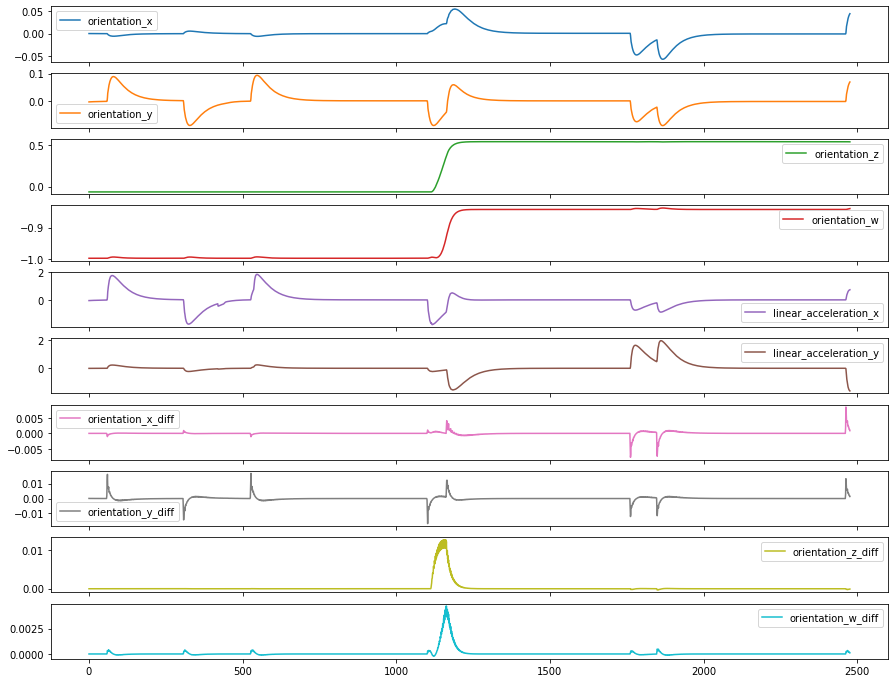

In [ ]:
otuput = x_df.plot(subplots=True, figsize=(15,12))

###### Plot

All Columns plot


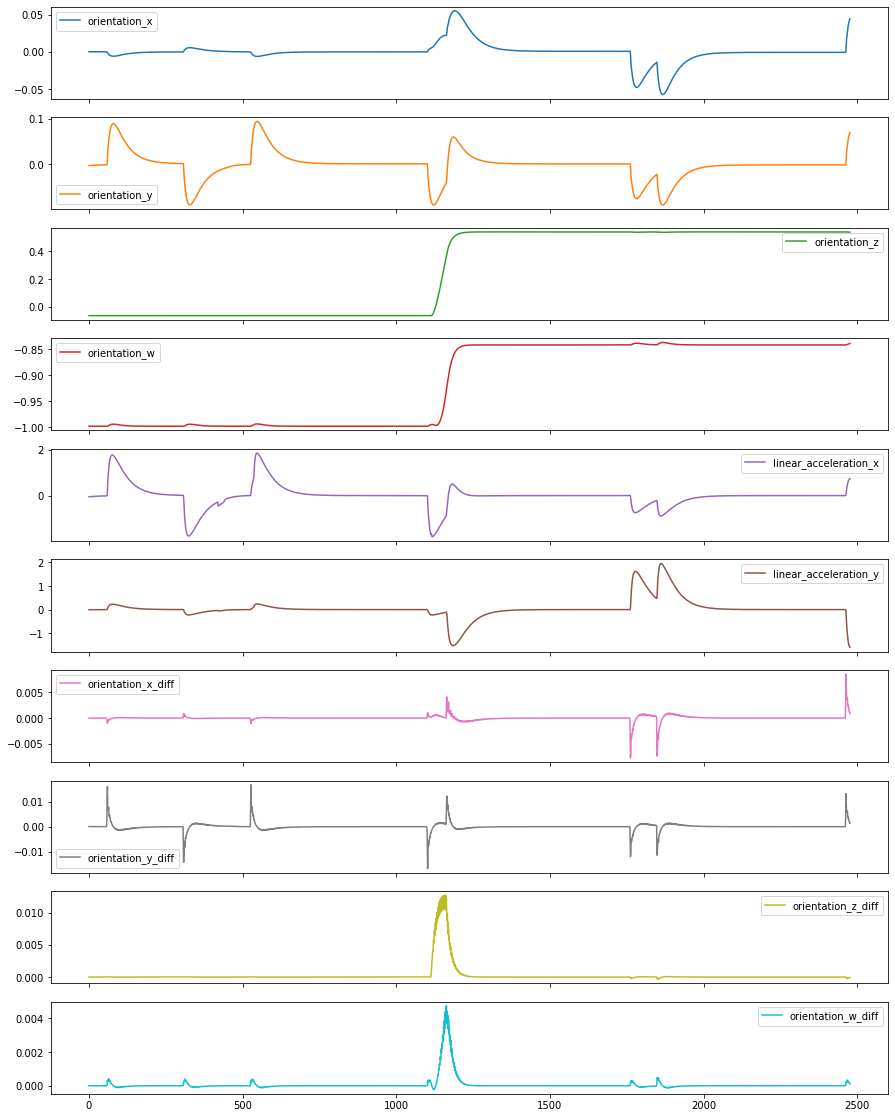

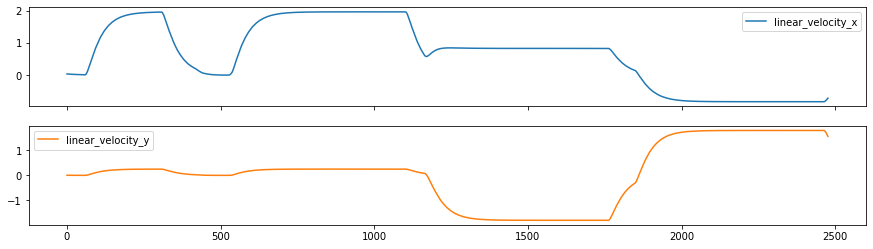

In [ ]:
print("All Columns plot")
otuput = x_df.plot(subplots=True, figsize=(15,20))
otuput = y_df.plot(subplots=True, figsize=(15,4))

###### Hist

All Columns plot


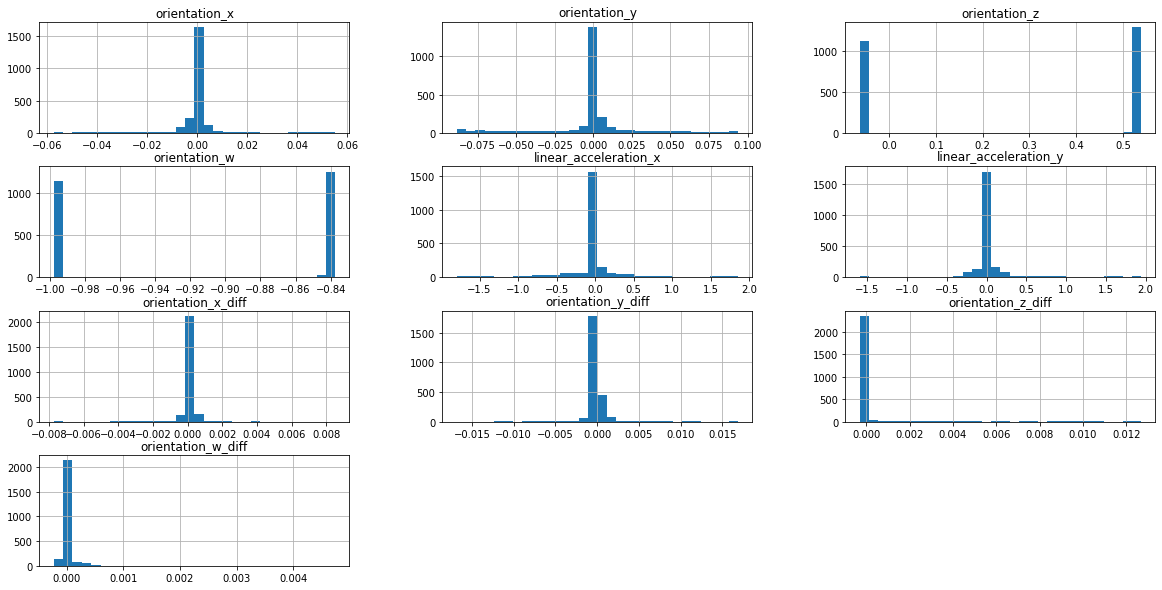

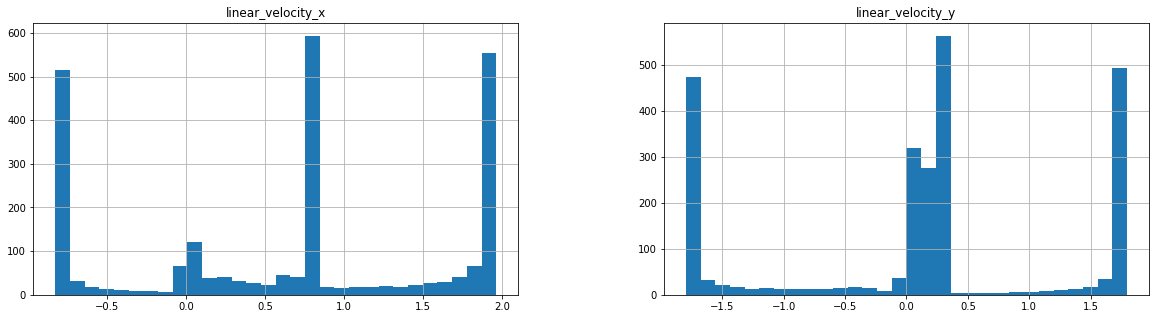

In [ ]:
print("All Columns plot")
otuput = x_df.hist(figsize=(20,10), bins=30)
otuput = y_df.hist(figsize=(20,5), bins=30)

#Model creation and training 

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_dataset(INPUT_COLUMNS, OUTPUT_COLUMNS)

In [ ]:
def create_ann_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount + len(ORIENTATION_SENSORS))),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(output_columns_amount, activation="linear")
    ])


    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.0005))
                    
    return model

def create_ann_tuned_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount)),
        layers.Dense(32, activation="sigmoid"),
        layers.Dense(output_columns_amount),
    ])
    

    learning_rate = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005,
        decay_steps=10000,
        decay_rate=0.9)

    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model

In [ ]:
model = create_ann_model(len(INPUT_COLUMNS), len(OUTPUT_COLUMNS))

history = model.fit(train_x,
          train_y,
          epochs=100,
          batch_size=512,
          validation_data=(dev_x, dev_y))

2022-04-23 20:38:52.484218: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-23 20:38:52.484247: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Legion-T5-26I0B6
2022-04-23 20:38:52.484251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Legion-T5-26I0B6
2022-04-23 20:38:52.484350: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-04-23 20:38:52.484366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-04-23 20:38:52.484378: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-04-23 20:38:52.484609: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following C

Epoch 1/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0381 - val_loss: 0.0248
Epoch 2/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0165 - val_loss: 0.0135
Epoch 3/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 4/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 5/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 6/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 7/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 8/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 9/100
1243/1243 [==============================] - 2s 2ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 10/100
1243/1243 [==============================] - 2s 2ms/step - l

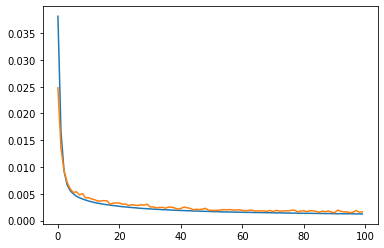

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

## Save model

In [ ]:
model_name = "ann_o2s_23Apr_1"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

2022-04-23 20:42:42.168919: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://91eaa994-d159-4b5d-b625-ab9df00b7b1f/assets


# Model tasting

In [25]:
from scipy.signal import savgol_filter

In [19]:
def plot_model_prediction(real_xy_speed, pred_xy_speed):
    real_xy_speed = np.round(real_xy_speed, decimals=3)
    pred_xy_speed = np.round(pred_xy_speed, decimals=3)
    real_xy_speed_without_zeros = real_xy_speed.copy()
    real_xy_speed_without_zeros[real_xy_speed_without_zeros == 0] = 1
    approximation_error = (100 * (np.absolute(pred_xy_speed - real_xy_speed) / np.absolute(real_xy_speed_without_zeros)).mean(axis=0))[0]
    print(f"approximation_error: {approximation_error}")
    
    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 0].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 0].reshape(-1, 1))

    plt.show()

    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 1].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 1].reshape(-1, 1))

    plt.show()

In [26]:
def test_model_prediction(model: tf.keras.Model,
                          scaler_x: MinMaxScaler,
                          scaler_y: MinMaxScaler, 
                          record_file_name: str) -> None:
  recording_path = os.path.join(DATA_FOLDER_PATH, record_file_name)
  x_df, real_xy_speed = load_flight_steps_from_file(recording_path, INPUT_COLUMNS, OUTPUT_COLUMNS)
  real_xy_speed = real_xy_speed.to_numpy()

  data_x = scaler_x.transform(x_df)
  pred_y = model.predict(data_x)
  pred_xy_speed = scaler_y.inverse_transform(pred_y.copy())

  # plot_model_prediction(real_xy_speed, pred_xy_speed)
  # for x in range(11,400, 2):
  #   print(x)
  #   pred_xy_speed = scaler_y.inverse_transform(pred_y.copy())
  #   pred_xy_speed[:, 0] = savgol_filter(pred_xy_speed[:, 0], 189,3, mode='mirror')
  #   # pred_xy_speed = pd.DataFrame(pred_xy_speed).ewm(span=30, adjust=False).mean().to_numpy()

  #   plot_model_prediction(real_xy_speed, pred_xy_speed)

  plot_model_prediction(real_xy_speed, pred_xy_speed)
  
  pred_xy_speed[:, 0] = savgol_filter(pred_xy_speed[:, 0], 189,3, mode='mirror')
  pred_xy_speed[:, 1] = savgol_filter(pred_xy_speed[:, 1], 189,3, mode='mirror')
    # pred_xy_speed = pd.DataFrame(pred_xy_speed).ewm(span=30, adjust=False).mean().to_numpy()

  plot_model_prediction(real_xy_speed, pred_xy_speed)

approximation_error: 490.42970401875056


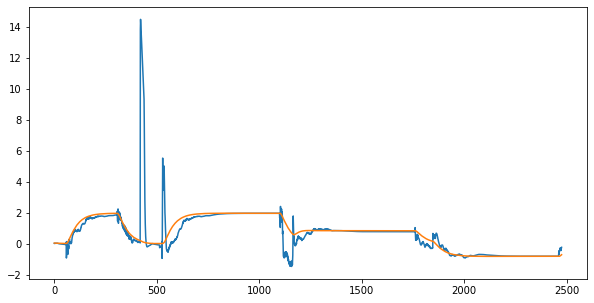

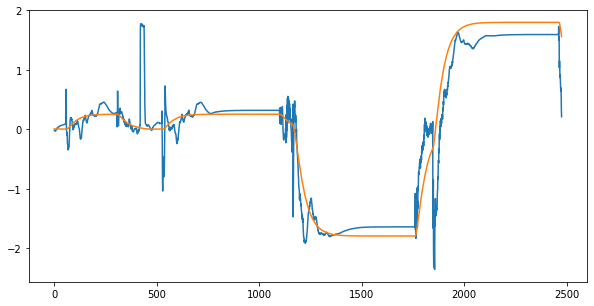

approximation_error: 872.3953629262007


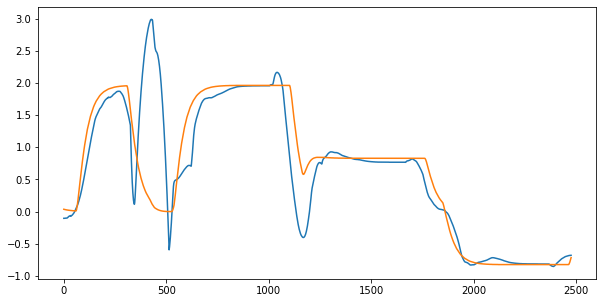

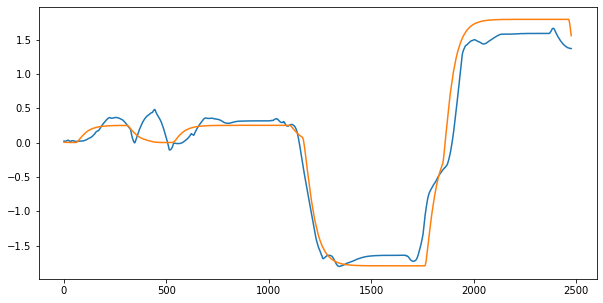

In [28]:
model, scaler_x, scaler_y = load_model_with_scalers_binary("ann_o2s_23Apr_1")
record_file_name = "manual_2022:04:22_20:38:48_record.csv"   
test_model_prediction(model, scaler_x, scaler_y, record_file_name)   

In [ ]:
for record_file_name in get_recordings_files()[::2]:
  test_model_prediction(model, scaler_x, scaler_y, record_file_name) 

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

# Hyperparameters tuning

### Model Creation

In [ ]:
def create_dynamic_model(hp: kt.HyperParameters) -> Model:
    """
    Creates Sequence model dynamically
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()
    model.add(layers.Input(shape=(hp.get("input_columns_amount"))))    

    dense_layers = hp.Int("dense_layers", min_value=1, max_value=3)
    for layer_id in range(dense_layers):
      layer_units = hp.Int(f"dense_{layer_id}_units", min_value=4, max_value=128)

      activation = hp.Choice("activation", values=["tanh", "sigmoid", "relu"])
      model.add(layers.Dense(layer_units, activation=activation))

      if hp.Boolean(f"dense_{layer_id}_dropout_status"):
          dropout_rate = hp.Float(f"dense_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
          model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hp.get("output_columns_amount")))

    learning_rate = hp.Choice("adam_learning_rate", [0.1, 0.05, 1e-2, 1e-3, 5e-3, 5e-4])

    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)

    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model



### The Tuner



In [ ]:
hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_COLUMNS)+ len(ORIENTATION_SENSORS))
hp.Fixed("output_columns_amount", len(OUTPUT_COLUMNS))

project_name = "ann_o2s_23AprDay"
tuner = kt.BayesianOptimization(
    create_dynamic_model,
    hyperparameters=hp,
    objective="val_loss",
    max_trials=2000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
    executions_per_trial = 1
)

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'input_columns_amount': 4,
 'output_columns_amount': 2,
 'dense_layers': 2,
 'dense_0_units': 16,
 'dense_0_dropout_status': True,
 'adam_learning_rate': 0.005,
 'learning_rate_decay': False,
 'dense_0_dropout_rate': 0.05,
 'dense_1_units': 44,
 'dense_1_dropout_status': True,
 'dense_2_units': 8,
 'dense_2_dropout_status': True,
 'dense_1_dropout_rate': 0.0}

In [ ]:
model = tuner.get_best_models()[0]
model_name = "speed_best_12Mar_10"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

### Truning

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 600,
             batch_size=512,
             callbacks=[early_stop, tensorboard_callback])



Trial 15 Complete [00h 02m 50s]
val_loss: 0.12319662421941757

Best val_loss So Far: 0.06660635024309158
Total elapsed time: 00h 26m 01s

Search: Running Trial #16

Hyperparameter    |Value             |Best Value So Far 
input_columns_a...|10                |10                
output_columns_...|2                 |2                 
dense_layers      |3                 |3                 
dense_0_units     |65                |27                
activation        |tanh              |tanh              
dense_0_dropout...|False             |False             
adam_learning_rate|0.01              |0.01              
learning_rate_d...|True              |True              
dense_1_units     |49                |105               
dense_1_dropout...|True              |True              
dense_2_units     |42                |10                
dense_2_dropout...|False             |False             
dense_1_dropout...|0                 |0.15              
dense_0_dropout...|0.4               